In [29]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.cuda import amp
from torch.optim.lr_scheduler import OneCycleLR

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from math import ceil, sqrt

import time

cmap='twilight_shifted'

In [45]:
input = torch.randn(4, 1, 2, 3,1)
input_2 = input.repeat(1,1,1,1,3)
truth = torch.randn(4, 1, 2, 3,1)
const = 1.0

diff = const * torch.norm(
    torch.flatten(input, start_dim=1) - torch.flatten(truth, start_dim=1),
    p=2,
    dim=-1,
    keepdim=False,
)
diff

tensor([2.5708, 3.5352, 1.3845, 1.6467])

In [46]:
x_flat = torch.swapaxes(torch.flatten(input_2, start_dim=1, end_dim=-2), 1, 2)
y_flat = torch.swapaxes(torch.flatten(truth, start_dim=1, end_dim=-2), 1, 2)

norm = const * torch.cdist(x_flat, y_flat, p=2)
norm

tensor([[[2.5708],
         [2.5708],
         [2.5708]],

        [[3.5352],
         [3.5352],
         [3.5352]],

        [[1.3845],
         [1.3845],
         [1.3845]],

        [[1.6467],
         [1.6467],
         [1.6467]]])

tensor(3.5202)


In [2]:
enable_amp = False

# set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(device.index)

In [3]:
from math import ceil

from torch_harmonics.examples.shallow_water_equations import ShallowWaterSolver

class PdeDataset(torch.utils.data.Dataset):
    """Custom Dataset class for PDE training data"""
    def __init__(self, dt, nsteps, dims=(384, 768), pde='shallow water equations', initial_condition='random',
                 num_examples=32, device=torch.device('cpu'), normalize=True, stream=None):
        self.num_examples = num_examples
        self.device = device
        self.stream = stream

        self.nlat = dims[0]
        self.nlon = dims[1]

        # number of solver steps used to compute the target
        self.nsteps = nsteps
        self.normalize = normalize

        if pde == 'shallow water equations':
            lmax = ceil(self.nlat/3)
            mmax = lmax
            dt_solver = dt / float(self.nsteps)
            self.solver = ShallowWaterSolver(self.nlat, self.nlon, dt_solver, lmax=lmax, mmax=mmax, grid='equiangular').to(self.device).float()
        else:
            raise NotImplementedError

        self.set_initial_condition(ictype=initial_condition)

        if self.normalize:
            inp0, _ = self._get_sample()
            self.inp_mean = torch.mean(inp0, dim=(-1, -2)).reshape(-1, 1, 1)
            self.inp_var = torch.var(inp0, dim=(-1, -2)).reshape(-1, 1, 1)

    def __len__(self):
        length = self.num_examples if self.ictype == 'random' else 1
        return length

    def set_initial_condition(self, ictype='random'):
        self.ictype = ictype
    
    def set_num_examples(self, num_examples=32):
        self.num_examples = num_examples

    def _get_sample(self):
        if self.ictype == 'random':
            inp = self.solver.random_initial_condition(mach=0.2)
        elif self.ictype == 'galewsky':
            inp = self.solver.galewsky_initial_condition()
            
        # solve pde for n steps to return the target
        tar = self.solver.timestep(inp, self.nsteps)
        inp = self.solver.spec2grid(inp)
        tar = self.solver.spec2grid(tar)        

        return inp, tar

    def __getitem__(self, index):

        # if self.stream is None:
        #     self.stream = torch.cuda.Stream()

        # with torch.cuda.stream(self.stream):
        #     with torch.inference_mode():
        #         with torch.no_grad():
        #             inp, tar = self._get_sample()

        #             if self.normalize:
        #                 inp = (inp - self.inp_mean) / torch.sqrt(self.inp_var)
        #                 tar = (tar - self.inp_mean) / torch.sqrt(self.inp_var)

        # self.stream.synchronize()

        with torch.inference_mode():
            with torch.no_grad():
                inp, tar = self._get_sample()

                if self.normalize:
                    inp = (inp - self.inp_mean) / torch.sqrt(self.inp_var)
                    tar = (tar - self.inp_mean) / torch.sqrt(self.inp_var)

        return inp.clone(), tar.clone()

In [30]:
# 1 hour prediction steps
dt = 11*3600
dt_solver = 150
nsteps = dt//dt_solver
dataset = PdeDataset(dt=dt, nsteps=nsteps, dims=(256, 512), device=device, normalize=True)
# There is still an issue with parallel dataloading. Do NOT use it at the moment
dataloader = DataLoader(dataset, batch_size=4, shuffle=True, num_workers=0, persistent_workers=False)
dataloader.dataset.set_initial_condition('random')
solver = dataset.solver.to(device)

nlat = dataset.nlat
nlon = dataset.nlon


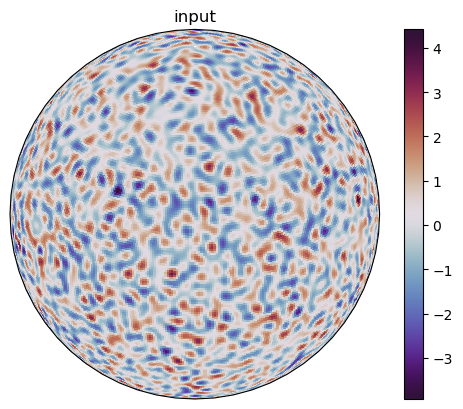

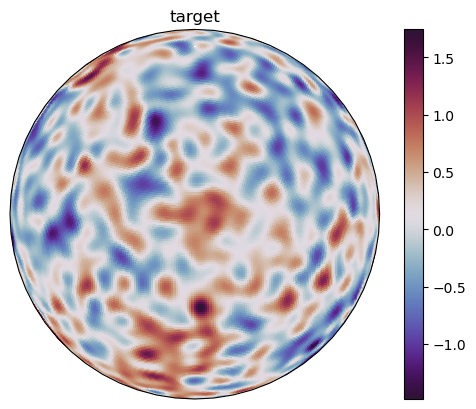

In [31]:
torch.manual_seed(100)
inp, tar = dataset[0]

fig = plt.figure()
im = solver.plot_griddata(inp[0], fig)
plt.title("input")
plt.colorbar(im)
plt.show()

fig = plt.figure()
im = solver.plot_griddata(tar[0], fig)
plt.title("target")
plt.colorbar(im)
plt.show()

# Test 2

In [1]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from math import ceil, floor

import sys

from torch_harmonics.sht import *
from torch_harmonics.examples import ShallowWaterSolver

In [2]:
enable_amp = False

# set device
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
if torch.cuda.is_available():
    torch.cuda.set_device(device.index)

In [3]:
# initialize parameters:
nlat = 256
nlon = 2*nlat
lmax = ceil(128)
mmax = lmax
# timestepping
dt = 75
maxiter = 10*int(3600/dt)

# initialize solver class
swe_solver = ShallowWaterSolver(nlat, nlon, dt, lmax=lmax, mmax=mmax).to(device)

lons = swe_solver.lons
lats = swe_solver.lats

jj, ii = torch.triu_indices(lmax, mmax)


In [4]:
uspec0 = swe_solver.random_initial_condition(mach = 0.2)

In [5]:
ctype = torch.complex128 if swe_solver.lap.dtype == torch.float64 else torch.complex64
mach = 0.2

llimit = mlimit = 80

# initial geopotential
uspec = torch.zeros(3, swe_solver.lmax, swe_solver.mmax, dtype=ctype, device=swe_solver.lap.device)
uspec[:, :llimit, :mlimit] = torch.sqrt(torch.tensor(4 * torch.pi / llimit / (llimit+1), device=device, dtype=ctype)) * torch.randn_like(uspec[:, :llimit, :mlimit])

uspec[0] = swe_solver.gravity * swe_solver.hamp * uspec[0]
uspec[0, 0, 0] += torch.sqrt(torch.tensor(4 * torch.pi, device=device, dtype=ctype)) * swe_solver.havg * swe_solver.gravity
uspec[1:] = mach * uspec[1:] * torch.sqrt(swe_solver.gravity * swe_solver.havg) / swe_solver.radius

uspec = torch.tril(uspec)

grid = swe_solver.spec2grid(uspec)

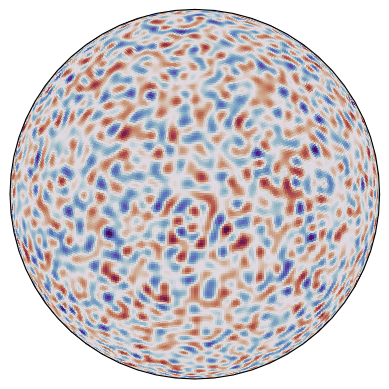

In [6]:
fig = plt.figure()
im = swe_solver.plot_griddata(grid[0], fig, cmap="twilight_shifted")
plt.show()

In [12]:
dudtspec = torch.zeros(3, 3, swe_solver.lmax, swe_solver.mmax, dtype=torch.complex128, device=device)
inew = 0
inow = 1
iold = 2

uspec = uspec0.clone().to(device)

# save for later:
nskip = 10
utspec = torch.zeros(floor(maxiter//nskip) + 1, *uspec.shape).cdouble().to(device)

with torch.inference_mode():
    for iter in range(maxiter+1):
        t = iter*dt

        if iter % nskip == 0:
            utspec[iter//nskip] = uspec
            print(f"t={t/3600:.2f} hours")

        dudtspec[inew] = swe_solver.dudtspec(uspec)
        
        # update vort,div,phiv with third-order adams-bashforth.
        # forward euler, then 2nd-order adams-bashforth time steps to start.
        if iter == 0:
            dudtspec[inow] = dudtspec[inew]
            dudtspec[iold] = dudtspec[inew]
        elif iter == 1:
            dudtspec[iold] = dudtspec[inew]

        uspec = uspec + swe_solver.dt*( (23./12.) * dudtspec[inew] - (16./12.) * dudtspec[inow] + (5./12.) * dudtspec[iold] )

        # implicit hyperdiffusion for vort and div.
        uspec[1:] = swe_solver.hyperdiff * uspec[1:]
        # cycle through the indices
        inew = (inew - 1) % 3
        inow = (inow - 1) % 3
        iold = (iold - 1) % 3

t=0.00 hours
t=0.21 hours
t=0.42 hours
t=0.62 hours
t=0.83 hours
t=1.04 hours
t=1.25 hours
t=1.46 hours
t=1.67 hours
t=1.88 hours
t=2.08 hours
t=2.29 hours
t=2.50 hours
t=2.71 hours
t=2.92 hours
t=3.12 hours
t=3.33 hours
t=3.54 hours
t=3.75 hours
t=3.96 hours
t=4.17 hours
t=4.38 hours
t=4.58 hours
t=4.79 hours
t=5.00 hours
t=5.21 hours
t=5.42 hours
t=5.62 hours
t=5.83 hours
t=6.04 hours
t=6.25 hours
t=6.46 hours
t=6.67 hours
t=6.88 hours
t=7.08 hours
t=7.29 hours
t=7.50 hours
t=7.71 hours
t=7.92 hours
t=8.12 hours
t=8.33 hours
t=8.54 hours
t=8.75 hours
t=8.96 hours
t=9.17 hours
t=9.38 hours
t=9.58 hours
t=9.79 hours
t=10.00 hours


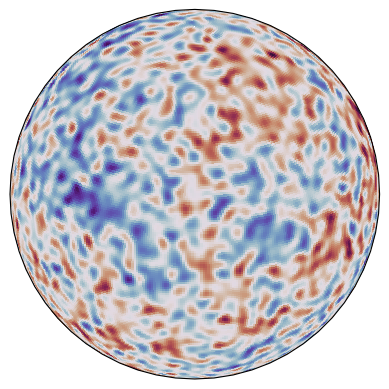

In [13]:
fig = plt.figure()
im = swe_solver.plot_specdata(uspec[0], fig, cmap="twilight_shifted")
plt.show()

In [14]:
utspec.shape

torch.Size([49, 3, 128, 128])

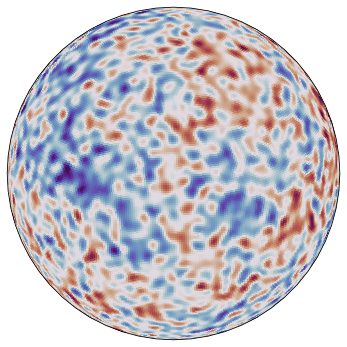

In [16]:
# prepare figure for animation
fig = plt.figure(figsize=(8, 6), dpi=72)
moviewriter = animation.writers['pillow'](fps=10)
moviewriter.setup(fig, 'zonal_jet.gif', dpi=72)

plot_pvrt = False

for i in range(utspec.shape[0]):
    t = i*nskip*dt

    if plot_pvrt:
        variable = swe_solver.potential_vorticity(utspec[i])
    else:
        variable = swe_solver.spec2grid(utspec[i, 0])

    plt.clf()
    # swe_solver.plot_griddata(variable, cmap=cmap, vmin=-0.2, vmax=1.8, title=f'zonal jet t={t/3600:.2f} hours')
    swe_solver.plot_griddata(variable, fig, cmap="twilight_shifted", antialiased=False)
    plt.draw()
    moviewriter.grab_frame()


moviewriter.finish()